## **Experiments conducted on LR-ASPP MobileNetV3 model with Adam Optimizer with following hyperparameters:<br>**
Learning rate: 0.0001 <br>
Batch Size = 20<br>
Epochs = 200<br>



### Importing all necessary libraries

In [3]:
# Import the required imports

from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import lraspp_mobilenet_v3_large
from torchvision.models.segmentation.lraspp import LRASPPHead
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.functional import interpolate as inter
from collections import OrderedDict


Load the directory for the dataset from Google Drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')
# os.listdir("drive/MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# specifying the zip file name
file_name = "underwater_sem_seg.zip"
with ZipFile("drive/MyDrive/underwater_sem_seg.zip", 'r') as zip:
    # zip.printdir()
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


Load the Dataset

In [13]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
folders = [root+"/"+i for i in entries[:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        #print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break

['sea_anemone_sem_seg_gt', 'otter_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'shrimp_sem_seg_gt', 'whale_sem_seg_gt', 'stingray_sem_seg_gt', 'octopus_sem_seg_gt', 'seal_sem_seg_gt', 'crab_sem_seg_gt', 'nettles_sem_seg_gt', 'dolphin_sem_seg_gt', 'squid_sem_seg_gt', 'frog_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shark_sem_seg_gt', 'turtle_sem_seg_gt', 'nudibranch_sem_seg_gt', 'seahorse_sem_seg_gt', 'star_fish_sem_seg_gt', 'penguin_sem_seg_gt', 'crocodile_sem_seg_gt']
['underwater_sem_seg/dataset/sea_anemone_sem_seg_gt', 'underwater_sem_seg/dataset/otter_sem_seg_gt', 'underwater_sem_seg/dataset/sea_urchin_sem_seg_gt', 'underwater_sem_seg/dataset/shrimp_sem_seg_gt', 'underwater_sem_seg/dataset/whale_sem_seg_gt', 'underwater_sem_seg/dataset/stingray_sem_seg_gt', 'underwater_sem_seg/dataset/octopus_sem_seg_gt', 'underwater_sem_seg/dataset/seal_sem_seg_gt', 'underwater_sem_seg/dataset/crab_sem_seg_gt', 'underwater_sem_seg/dataset/nettles_sem_seg_gt', 'underwater_sem_seg/dataset/dolphin_sem_seg_gt', 

Split the dataset into Training and Testing dataset


In [14]:
#Split the dataset into Training and Testing dataset
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

[251 171  47 106 538 401 152 196 146 234 501 189 519 342 444 324 320 408
 571 386 241 158 139 566 188  60 362 415  17 280 482  35 569 352 226 375
  79 496 193 551 122 381 394  11 461 481 318 303 129 222 306 261 361 149
   9 463 102 400  86 443 535 455 428 259 370 366 468  59 473 429 445 191
  54 267 545 308 513 233 464 446  37 526 533 160 105 219 285 125 338  45
  67  92 176 483 142 173 224 128  63 414 262 254 293 243 114 220 494  42
 327 291 382  16 524 295 258 508 409 447  61 484 230 181   2 554 321 281
  99  48 348 159 203  97 553 263 462  65 115 522 543 561 300 123 567 391
 286 528 165   0 426 317 120 476 162 479 407 505 121 213  18 570 269 467
 265 322 302  27 154 534 480 550 104 423 540 437 515 172 136 406 194 266
 131 164   7 373 161  71 127 190 335 117 546 486 556 380  33 113 284 363
  84 305 449 185 343 187 186 207 333 503 402 435  62 397 459  96  41 148
 345 145  49  39  55  30  78 410 403  40  51 315 498 393 112 537 424 217
 225 536 235 487 350 288 279 510 246 405 527 559   

### Data Augmentation
As our data size is not large, we are augmenting some of the images in the training data. 
Following are the operations performed while augmenting images:
1.	Horizontal flip (on random 200 images of training data) 
2.	Shifting to right by 20 pixels (on random 200 images of training data) 
3.	Shifting to left by 20 pixels (on random 100 images of training data) 
4.	Shifting to up by 20 pixels (on random 100 images of training data)
5.	Shifting to down by 20 pixels (on random 100 images of training data)

We have reffered a [link](https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd) to perform data augmentation.

In [ ]:
# https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd

#horizontal flip
randn = list(np.random.randint(low = 0,high=490,size=200))
for i in randn:
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)
  # perform horizontal flip
  images_train.append(np.fliplr(im))
  masks_train.append(np.fliplr(target))

#shift right
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[:, shift:] = im[:, :-shift]
  target[:, shift:] = target[:, :-shift]
  images_train.append(im)
  masks_train.append(target)


#shift left
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[:, :-shift] = im[:, shift:]
  target[:, :-shift]= target[:, shift:]
  images_train.append(im)
  masks_train.append(target)


#shift up
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[:-shift, :] = im[shift:, :]
  target[:-shift, :] = target[shift:, :]
  images_train.append(im)
  masks_train.append(target)


#shift down
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[shift:, :] = im[:-shift,:]
  target[shift:, :] = target[:-shift,:]
  classes_train.append(im)
  masks_train.append(target)

  # -------------------end------------------------

### Creating custom dataset class for dataloaders.

In [ ]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform, transform_label):
        self.input=input_data
        self.mask = mask
        self.transforms = transform
        self.transforms_label = transform_label


    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms_label(z)
            z = torch.tensor(np.asarray(z))
            #class number 31 = other class is labelled as 0 in dataloader.
            z[z == 31] = 0
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=20
    epochs = 200
    HEIGHT= 256
    WIDTH = 256


### Performing transforms on data and creation of dataloaders.

In [ ]:

from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode as interpolate

transforms_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
transforms_label = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256), interpolate.NEAREST)])
#, transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms_image,transforms_label)
test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)
# final_test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())

# final_test_gen = DataLoader(final_test_set,shuffle=False,batch_size=1, pin_memory=False,num_workers=os.cpu_count())

Implementation of LR-ASPP MobileNetV3Large

In [ ]:

# Implementation of LR-ASPP MobileNetV3Large

"""
The classifier returns 32*32 dense predictions, so we have upsampled the output predictions using Transpose convolutions. 
We refered https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py and https://github.com/mseg-dataset/mseg-semantic to upsample the predictions.
We were getting weird artifacts at the predicted images by doing just the transpose convolutions. So we added some Activation and BatchNorm Layers to remove them 
as shown in https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py. 
"""

#Source for the class LRASPP: https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/lraspp.html

"""
The LRASPP classmplements a Lite R-ASPP Network for semantic segmentation from `"Searching for MobileNetV3" <https://arxiv.org/abs/1905.02244>`_.
This implementation consists of separate arguments for high level and low level features, which makes it different from FCNResnet and Deeplabv3
It passes the following arguments:

1. backbone (nn.Module): the network used to compute the features for the model.The backbone should return an OrderedDict[Tensor], with the key being
"high" for the high level feature map and "low" for the low level feature map.

2. low_channels (int): the number of channels of the low level features.

3. high_channels (int): the number of channels of the high level features.

4. num_classes (int, optional): number of output classes of the model (including the background). inter_channels (int, optional): the number of 
channels for intermediate computations.
    """


from torch.nn import functional as F
class MyLRASPP(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyLRASPP, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        #if pretrained:
        net = lraspp_mobilenet_v3_large(pretrained=pretrained,                             
                            pretrained_backbone= True)#num_classes=31)
                
        
        self.backbone   = net.backbone

    

        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(31, 31, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(31)
        self.deconv2 = nn.ConvTranspose2d(31, 31, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(31)
        self.deconv3 = nn.ConvTranspose2d(31, 31, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(31)
        
        self.deconv4 = nn.ConvTranspose2d(31, 31, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(31)
        self.deconv5 = nn.ConvTranspose2d(31, 31, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.bn5     = nn.BatchNorm2d(31)
        self.final = nn.Conv2d(31, num_classes, kernel_size=1)

        high_channels=960
        low_channels=40
        inter_channels=25
        self.cbr = nn.Sequential(
            nn.Conv2d(high_channels, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
        )
        self.scale = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(high_channels, inter_channels, 1, bias=False),
            nn.Sigmoid(),
        )
        self.low_classifier = nn.Conv2d(low_channels, num_classes, 1)
        self.high_classifier = nn.Conv2d(inter_channels, num_classes, 1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, input):
        #print(x)
        
        input = self.backbone(input)

            
        
        low = input["low"]
        high = input["high"]

        x = self.cbr(high)
        s = self.scale(high)
        x = x * s
        x = inter(x, size=low.shape[-2:], mode="bilinear", align_corners=False)

        out=self.low_classifier(low) + self.high_classifier(x)
        
        

        out = inter(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        result = OrderedDict()
        result["out"] = out

        score = self.relu(self.deconv2(self.bn1(out)))            # size=(2, 256, x.H/4, x.W/4)
        score = self.bn2(score) 
        
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        if self.training:

            return score
       
        else:
            return score

        """
        ----------- End of reffered code --------------
        """


Load the model

In [ ]:
model = MyLRASPP(num_classes = 31)

Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth


  0%|          | 0.00/12.5M [00:00<?, ?B/s]

### Defining loss function an optimizers

In [ ]:
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

### Creating dictionary of classes

In [ ]:
classes = ["other","crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

### Setting device as GPU if available and CPU otherwise.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Function used to train the model

In [ ]:
# training_total_loss=[]

import torchvision.transforms.functional as F

def training(model): 
    model.to(device)
    temp_train = 0
    training_loss=0
    model.train(True)
    
    with torch.set_grad_enabled(True):
        for batch,labels in train_gen:
    
            batch=batch.float().to(device)
   

            predictions=model(batch)
            npred = torch.softmax(predictions,dim=1)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
            temp_train  += pred_loss * hyperparam.bs

            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
        
    training_loss = temp_train / len(train_gen.dataset)
    print("Training avg loss = ",training_loss)
    return training_loss

### Function used to validate the model

In [ ]:

def validate(model):
    testing_avg_loss=0
    testing_loss=0
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
        for batch,labels in test_gen:
            batch=batch.float().to(device)
            predictions=model(batch)
            npred = torch.softmax(predictions,dim=1)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
            testing_loss += pred_loss * hyperparam.bs
            
        testing_avg_loss = testing_loss/len(test_gen.dataset)
        print("Test avg loss = ",testing_avg_loss)
        return testing_avg_loss


### Functions to find mIOU metric and accuracy value. <br>
We reffered the implementation of these metrics for semantic segmentation from the following links. <br>
https://github.com/mseg-dataset/mseg-semantic<br>
https://github.com/mseg-dataset/mseg-semantic/tree/master/mseg_semantic/utils<br>

In [ ]:
def Calculate_mIOU(output,target):
    #flatten the tensor to 1-D arrays
    k=31
    output = output.flatten().clone()
    target = target.flatten()
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
    area_output,_=np.histogram(output,bins=np.arange(k+1))
    area_target,_=np.histogram(target,bins=np.arange(k+1))
    area_union=area_output+area_target-area_intersection
    return area_intersection,area_union,area_target

In [ ]:
class calculate():
    def __init__(self):
        self.intersection_sum=0
        self.union_sum=0
        self.target_sum=0
        self.count=0
    def add(self,output,target):
        area_intersection,area_union,area_target=Calculate_mIOU(output,target)
        self.intersection_sum+=area_intersection
        self.union_sum+=area_union
        self.target_sum+=area_target
        self.count+=1
    def calculate_accuracy(self):
        accuracy= sum(self.intersection_sum)/sum(self.target_sum + 1e-10)
        maccuracy=np.mean(self.intersection_sum/(self.target_sum + 1e-10))
        iou = self.intersection_sum/(self.union_sum + 1e-10)
        miou=np.mean(iou)
        return miou,maccuracy,accuracy

### Training and validation of the model.<br>
All the losses are stored in lists used to plot the loss in a graph later.

In [ ]:
training_all_loss = []
validation_all_loss = []
index_count=0
for epochs in range(hyperparam.epochs):
    t_avg_loss = training(model)
    training_all_loss.append(t_avg_loss.cpu().detach().numpy())
    
    d_avg_loss = validate(model)
    validation_all_loss.append(d_avg_loss.cpu().detach().numpy())
    index_count+=1
    print(index_count)
    # scheduler.step(d_avg_loss)
torch.save(model,'LRASPPModelhere1.pth')

Training avg loss =  tensor(3.4597, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.7271, device='cuda:0')
1
Training avg loss =  tensor(3.4221, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.6648, device='cuda:0')
2
Training avg loss =  tensor(3.3311, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.5864, device='cuda:0')
3
Training avg loss =  tensor(3.2339, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.5222, device='cuda:0')
4
Training avg loss =  tensor(3.1855, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4990, device='cuda:0')
5
Training avg loss =  tensor(3.1639, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4976, device='cuda:0')
6
Training avg loss =  tensor(3.1534, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4885, device='cuda:0')
7
Training avg loss =  tensor(3.1445, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4

Visualizing Training and validation loss

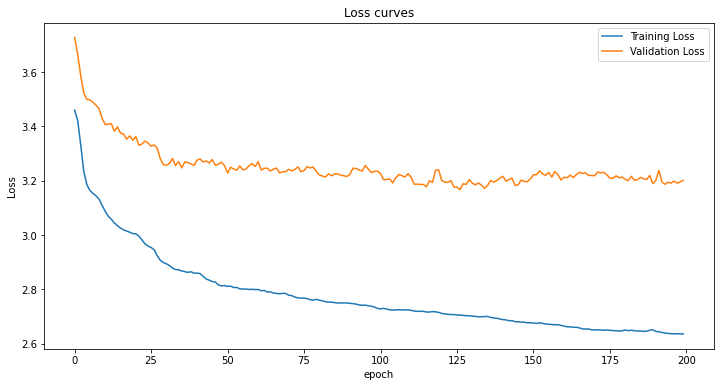

In [ ]:
import matplotlib.pyplot as plt
# training_total_loss = [ i.detach().numpy() for i in training_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(training_all_loss)),training_all_loss)
plt.plot(range(len(validation_all_loss)),validation_all_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Loss curves')
plt.show()


### Calculation of training and testing metrics: 
mIOU = mean Intersection over union<br>
maccuracy = mean accuracy of all classes<br>
Accuracy<br>

In [ ]:


import torchvision.transforms as T

        
def calculate_metrics(model):

    cal_metrics=calculate()
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in train_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics.add(predicted_masks.cpu(),labels.cpu()) 
        print("Training set: miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())

    cal_metrics_=calculate()
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in test_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics_.add(predicted_masks.cpu(),labels.cpu()) 
        print("Testing set: miou,maccuracy,accuracy: ",cal_metrics_.calculate_accuracy())

calculate_metrics(model)

Training set: miou,maccuracy,accuracy:  (0.47361645960893195, 0.5829357527565433, 0.8835806952582466)
Testing set: miou,maccuracy,accuracy:  (0.21029227802213563, 0.33666650301654977, 0.567229114879261)


### Testing Phase

We predicted the segmentation masks using our trained model.

In [ ]:

import torchvision.transforms.functional as F

testing_total_loss=0
testing_loss=0
model.to(device)
model.eval()
print("here")
All_predicted_test_masks = []
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float().to(device)
        labels=labels.float()
        predictions=model(batch)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.argmax(predictions,dim=1)
        All_predicted_test_masks.append((batch,labels,npred))

here
here1


### Visualization of outputs.

Pallete to visualize 31 different classes

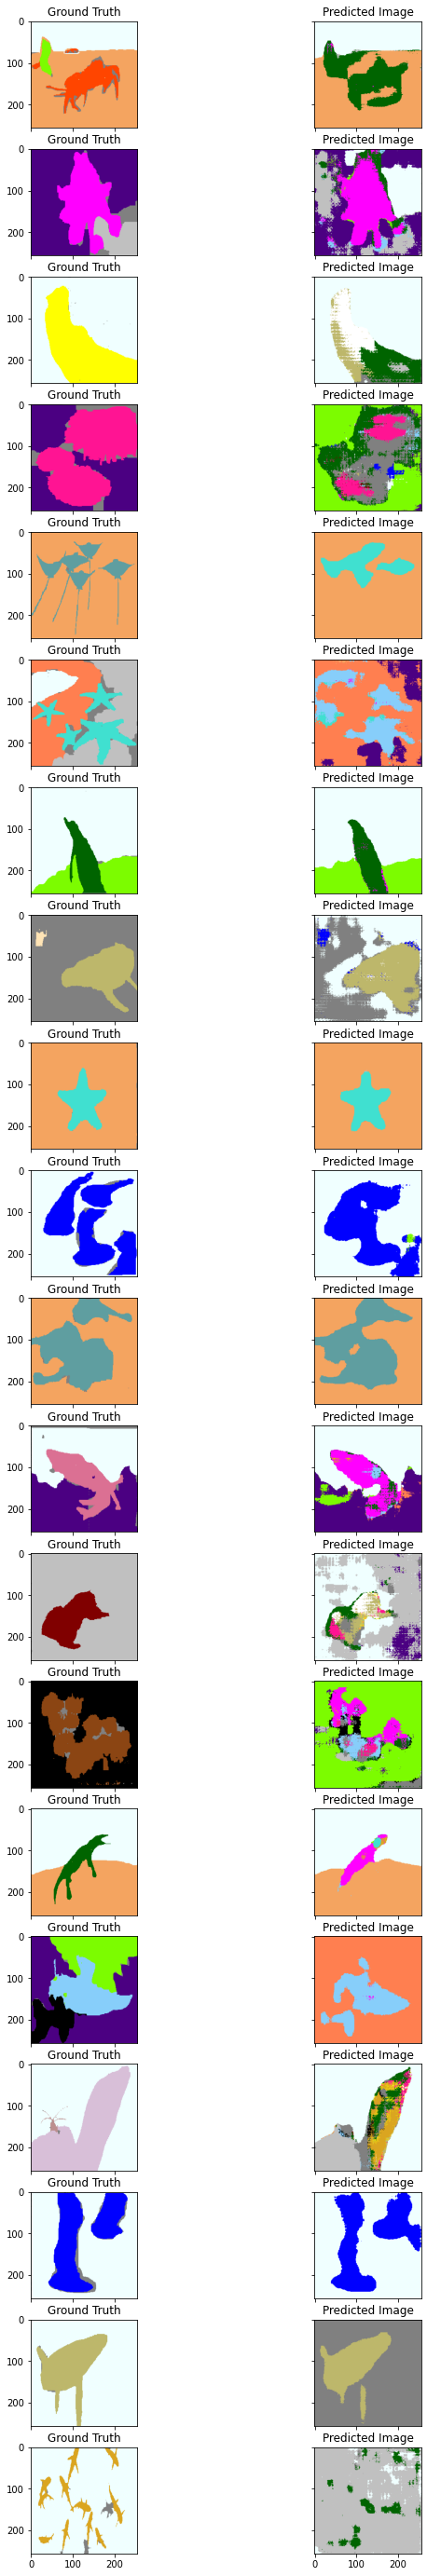

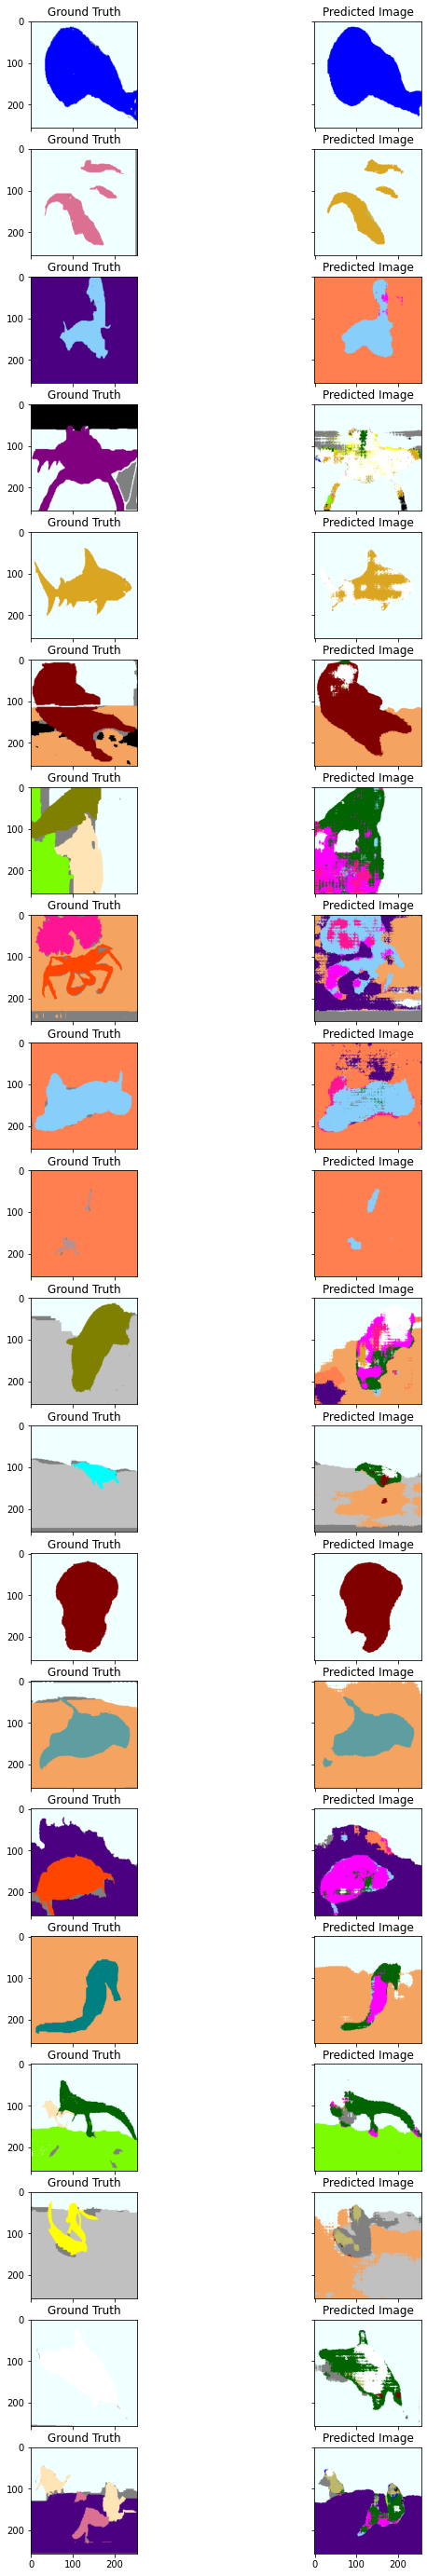

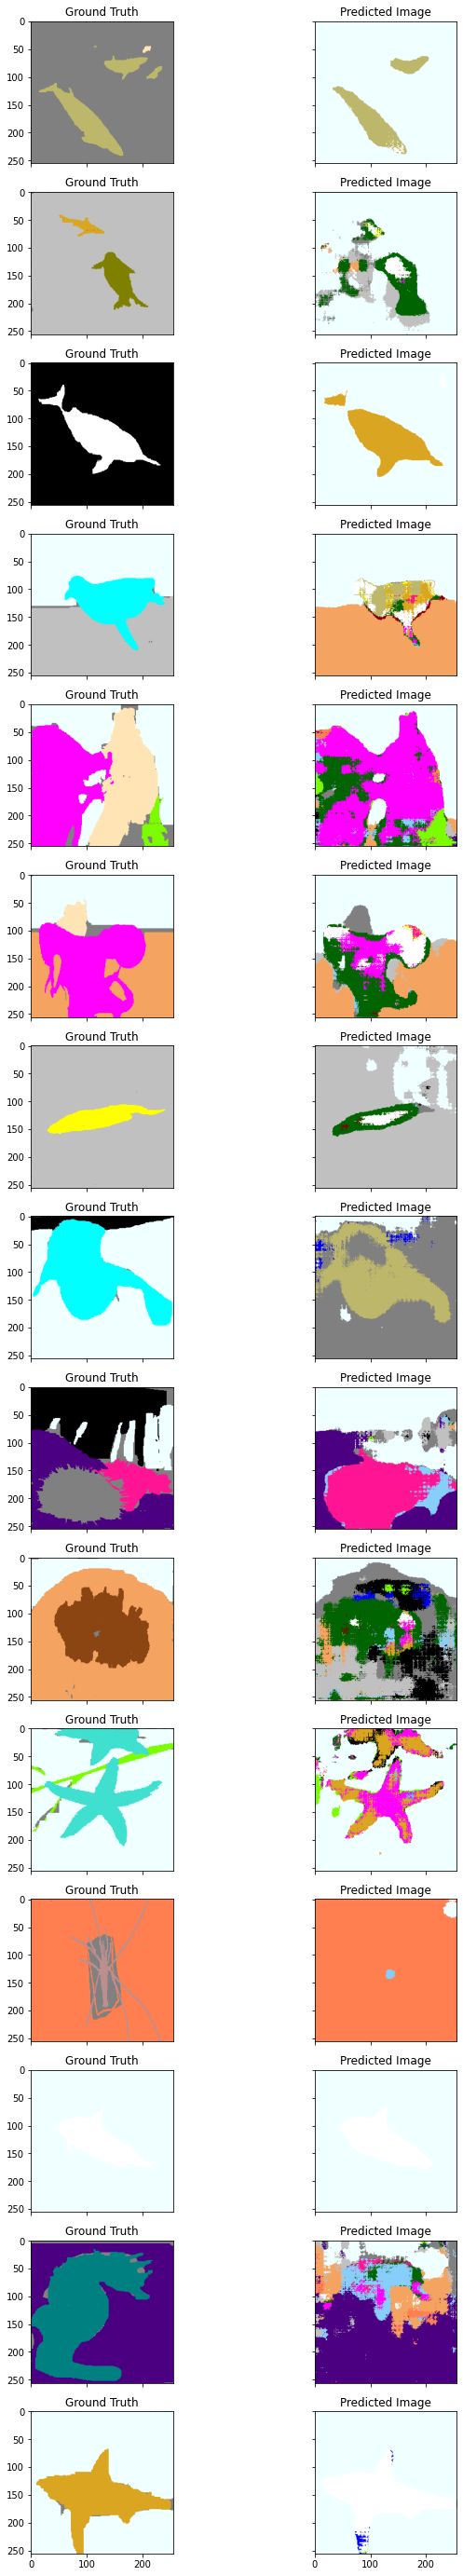

In [ ]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
palette = np.array([[128,128,128],   # gray 0 other
                    [255,69,0],      # orange 1 crab
                    [0,100,0],       # green 2 crocodile
                    [255,255,255],   # white 3  dolphin
                    [128,0,128],     # purple 4 frog
                    [0,0,255],       # blue 5 nettles
                    [255,0,255],     # Magenta 6 octopus
                    [255,255,0],     # Yellow 7 otter
                    [0,255,255],     # Cyan 8 penguin
                    [128,0,0],       # maroon 9 polar_bear
                    [255,20,147],    # deep pink 10 sea_anemone
                    [139,69,19],      # saddle brown 11 sea_urchin
                    [0,128,128],     # Teal 12  seahorse
                    [128,128,0],     # Olive 13 seal
                    [218,165,32],    # golden 14  shark
                    [188,143,143],   # 	rosy brown 15 shrimp 
                    [64,224,208],    # turquoise 16 star_fish
                    [95,158,160],    # cadet blue 17 stingray
                    [219,112,147],   # Pale Violet Red 18 squid
                    [216,191,216],   # thistle 19 turtle
                    [189,183,107],   # 	dark khaki 20 whale
                    [135,206,250],   # light sky blue 21 nudibranch
                    [255,127,80],   # coral 22 coral
                    [192,192,192],   # silver 23 rock
                    [240,255,255],   # azure 24 water
                    [244,164,96],   # sandy brown 25 sand
                    [124,252,0],   # lawn green 26 plant
                    [255,228,181],   # moccasin 27 human
                    [176,196,222],   # light steel blue 28 ice berg
                    [75,0,130],   # indigo 29 reef
                    [  0,   0,   0]   # Black 30 fish          
                    ])


import matplotlib
import matplotlib.pyplot as plt
def show(labels,npred,Image_number):

    cmap=matplotlib.cm.spring
    # print(len(npred))
    fix, axs = plt.subplots(nrows = len(npred) ,ncols=2,sharex=True, sharey=True, squeeze=False, figsize=(10,50))

    # fix.tight_layout()
    for i in range(len(npred)):
        #print(len(mask.detach().numpy()))
        #print(mask.detach().numpy().size())
        mask=npred[i].detach().numpy().astype(int)
        gt=labels[i].detach().numpy().astype(int)
        axs[i,0].set_title("Ground Truth")
        RGB = palette[gt]
        axs[i, 0].imshow(RGB)
        axs[i,1].set_title("Predicted Image")
        RGB = palette[mask]
        axs[i,1].imshow(RGB)
        

Image_num = 0
for batch,labels,npred in All_predicted_test_masks:
    show(labels,npred,Image_num)

Other References:<br>
https://pytorch.org/vision/stable/generated/torchvision.models.segmentation.lraspp_mobilenet_v3_large.html#torchvision.models.segmentation.lraspp_mobilenet_v3_large<br>
https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py